## 식사 인원 예측
### 필요하다고 생각되는 데이터 전처리들
1. 요일별 출근 인원 대비 중식계, 석식계 평균, 비율
2. 야근 근무자 수 대비 석식계 평균
3. 인원수 대비 가장높은 중식계, 석식계 메뉴 확인 (top 3)
4. 특정 메뉴가 들어있을 때와 없을 때의 중식계, 석식계 평균
- 메뉴의 정보만을 저장하는 dataframe을 새롭게 만들고 heatmap을 통해 어떤 메뉴가 가장 중식계, 석식계 비율에 영향을 크게 주는지 확인
- 중식계, 석식계 비율이 top 인 메뉴의 메인메뉴, 국, 디저트 정보를 확인
- 중식계메뉴, 석식계 메뉴에 가장 인기있는 메뉴들이 들어있는 경우와 없는 경우간의 중식계비율, 석식계 비율 확인
5. 데이터처리
- 원산지 정보는 각 재료에 대해 동일한 원산지의 정보를 가지므로 크게 영향을 주는 정보는 아니라고 생각하여 삭제
- 조식메뉴는 원하는 결과에 포함되지 않으므로 삭제
- 식사가능 인원대비 식사인원 수를 비율로 나타낸 column 추가 (중식계비율, 석식계비율)
- 야근 인원수 대비 석식계 확인
- 년, 월, 일 column 추가
- 년(year)별 중식, 석식 식사율 확인
- 달(month)별 중식, 석식 식사율 확인
- 일(day)별 식사율 확인
- 매 달 휴일 횟수 측정 -> 휴일의 수와 식사량 간의 상관관계


### 데이터 불러오기

In [32]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['font.family'] = 'NanumGothic'

In [33]:
train = pd.read_csv(os.getenv("HOME")+"/aiffel/dacon/train.csv")
test = pd.read_csv(os.getenv("HOME")+"/aiffel/dacon/test.csv")
submission = data = pd.read_csv(os.getenv("HOME")+"/aiffel/dacon/sample_submission.csv")

In [34]:
# 데이터 형태 확인
train.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


In [35]:
# object 포함 describe 확인
train.describe(include='O')

,일자,요일,조식메뉴,중식메뉴,석식메뉴
count,1205,1205,1205,1205,1205
unique,1205,5,1204,1198,1168
top,2017-08-30,목,모닝롤/프렌치토스트 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 무채국 김...,쌀밥/잡곡밥 (쌀:국내산) 차돌된장찌개 주꾸미볶음 옥수수전 양념깻잎지 포기김...,*
freq,1,244,2,2,19


In [36]:
train.shape

(1205, 12)

### 전처리 시작

In [37]:
# 조식메뉴 삭제
train.drop(['조식메뉴'], axis=1, inplace=True)
test.drop(['조식메뉴'], axis=1, inplace=True)

* submission 이 중식, 석식에 관한 내용이므로 조식메뉴 삭제

In [38]:
# 년, 월, 일 추출
train['년도'] = pd.to_datetime(train['일자']).dt.year
train['월'] = pd.to_datetime(train['일자']).dt.month
train['일'] = pd.to_datetime(train['일자']).dt.day

test['년도'] = pd.to_datetime(test['일자']).dt.year
test['월'] = pd.to_datetime(test['일자']).dt.month
test['일'] = pd.to_datetime(test['일자']).dt.day

In [39]:
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일
0,2016-02-01,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1


In [40]:
import re

# 괄호 안의 원산지 데이터 제거, 코드 수정 예정

# train['중식메뉴'] = re.sub(r'\([^)]*\)', '', train['중식메뉴'])
# train['석식메뉴'] = re.sub(r'\([^)]*\)', '', train['석식메뉴'])

# test['중식메뉴'] = re.sub(r'\([^)]*\)', '', train['중식메뉴'])
# test['석식메뉴'] = re.sub(r'\([^)]*\)', '', train['중식메뉴'])

In [41]:
# 결과 확인
train.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일
0,2016-02-01,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1
1,2016-02-02,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016,2,2


In [42]:
test.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,년도,월,일
0,2021-01-27,수,2983,88,182,5,358.0,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27


In [45]:
# 전체 출근인원대비 중식계, 석식계 비율 추가
train['중식계비율'] = train['중식계'] / (train['본사정원수'] - train['본사휴가자수'] - train['본사출장자수'] - train['현본사소속재택근무자수'])
train['석식계비율'] = train['석식계'] / (train['본사정원수'] - train['본사휴가자수'] - train['본사출장자수'] - train['현본사소속재택근무자수'])

In [46]:
# 확인
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
0,2016-02-01,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1,0.432736,0.137859


### 간단한 시각화

In [47]:
# 요일별 중식계, 석식계 평균

df_day = train[['요일', '중식계']].groupby(['요일']).mean()
df_day = pd.DataFrame(df_day, index = ['월', '화', '수', '목', '금'])

df_night = train[['요일', '석식계']].groupby(['요일']).mean()
df_night = pd.DataFrame(df_night, index = ['월', '화', '수', '목', '금'])

print(df_day)
print(df_night)

           중식계
월  1144.331950
화   925.620833
수   905.213389
목   823.991803
금   653.609959
          석식계
월  538.933610
화  520.129167
수  363.615063
목  480.401639
금  404.979253


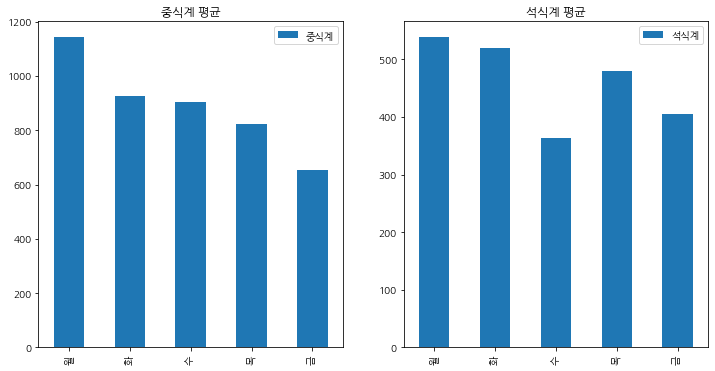

In [48]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
df_day.plot.bar(ax=ax[0])
ax[0].set_title('중식계 평균')
df_night.plot.bar(ax=ax[1])
ax[1].set_title('석식계 평균')
plt.show()

* 중식계의 경우 금요일로 갈 수록 식사 인원수가 적어진다.
* 석식계도 마찬가지 현상을 보이지만 특이하게 수요일에 식사 인원수가 확 떨어진다.

In [49]:
# 요일별 중식계, 석식계 평균 비율

df_day_ratio = train[['요일', '중식계비율']].groupby(['요일']).mean()
df_day_ratio = pd.DataFrame(df_day_ratio, index = ['월', '화', '수', '목', '금'])

df_night_ratio = train[['요일', '석식계비율']].groupby(['요일']).mean()
df_night_ratio = pd.DataFrame(df_night_ratio, index = ['월', '화', '수', '목', '금'])


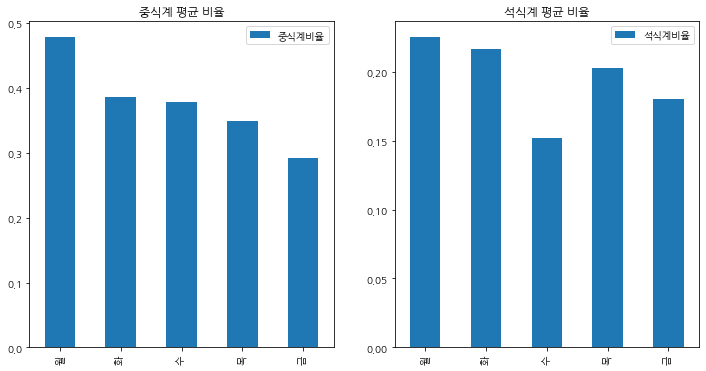

In [50]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
df_day_ratio.plot.bar(ax=ax[0])
ax[0].set_title('중식계 평균 비율')
#ax[0].set_xticklabels(rotation='horizontal')
df_night_ratio.plot.bar(ax=ax[1])
ax[1].set_title('석식계 평균 비율')
plt.show()

* 전체 인원대비 식사인원의 평균비율을 확인 해 봤을 때, 앞의 평균 그래프와 동일한 패턴을 보인다.

In [51]:
# 요일별 야근 근무자
tmp = train[['요일', '본사시간외근무명령서승인건수']].groupby(['요일']).mean()
df_night_worker = pd.DataFrame(tmp, index = ['월', '화', '수', '목', '금'])

In [52]:
# 야근자 수 대비 석식계 평균

# 추후에 구현 해볼 예정


### 인기 메뉴 선별
- 중식계비율, 석식계비율이 높은 날의 메뉴일 수록 인기메뉴라고 볼 수 있다.
- 메뉴의 정보만을 저장하는 dataframe을 재 정의 하고 heatmap을 통해 어떤 메뉴가 가장 중식계, 석식계 비율에 영향을 주는지 확인
- 가장 영향력이 높은 메뉴 = 인기메뉴

In [53]:
# 중식계 비율이 가장 높은 날
train.loc[train['중식계비율'] == train['중식계비율'].max()]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
1170,2020-12-01,화,2990,204,161,878,408.0,쌀밥/찰보리밥/찰현미밥 김치두부국 LA갈비구이 한식잡채 삼색유자청무침 포기김치/오프...,마파두부 홍합짬뽕국 샤워크림새우 물만두찜*장 짜사이볶음 백김치,1324.0,685.0,2020,12,1,0.597203,0.308976


* 중식계비율(점심을 먹은 사람)의 최대치는 60% 정도 된다.

In [54]:
# 출근인원의 절반이상이 중식을 먹은 경우. 인기메뉴로 결정 할까?
train.loc[train['중식계비율'] >= 0.5]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
5,2016-02-11,목,2601,383,143,417,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",1045.0,550.0,2016,2,11,0.503614,0.265060
7,2016-02-15,월,2601,87,204,482,0.0,쌀밥/잡곡밥 (쌀:국내산) 시금치국 닭감자조림 (닭고기:국내산) 연두부*양념장 ...,"쌀밥/잡곡밥 (쌀:국내산) 홍합미역국 등갈비김치찜 (돼지고기,김치:국내산) 임연수...",1268.0,672.0,2016,2,15,0.548918,0.290909
12,2016-02-22,월,2601,90,207,434,0.0,쌀밥/오곡밥 (쌀:국내산) 쇠고기느타리국 갈치구이 호박꼬지&고사리&무나물 파래...,쌀밥/잡곡밥 (쌀:국내산) 옹심이만두국 떡갈비조림 청포묵무침 부추오이생채 포...,1298.0,645.0,2016,2,22,0.563368,0.279948
21,2016-03-07,월,2624,50,195,456,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 콩나물국 닭갈비 (닭고기:국내산) 모둠묵*양념...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 대구찌개 돈육굴소스볶음 감자채볶음 물파래무침...",1326.0,625.0,2016,3,7,0.557377,0.262715
26,2016-03-14,월,2624,61,183,376,0.0,쌀밥/잡곡밥 (쌀:국내산) 어묵국 돈육고추장볶음 (돼지고기:국내산) 모둠양채쌈*쌈...,쌀밥/잡곡밥 (쌀:국내산) 달래된장찌개 간장찜닭 (닭고기:국내산) 통도라지구이 참...,1286.0,586.0,2016,3,14,0.540336,0.246218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,2020-12-16,수,2990,195,187,1,359.0,쌀밥/흑미밥/찰현미밥 (New)돈갈비김치찌개 해물완자전 가자미무조림 시금치나물 겉절...,흑미밥 쇠고기무국 오징어떡볶음 물파래초무침 숙주미나리나물 포기김치,1135.0,450.0,2020,12,16,0.504669,0.200089
1184,2020-12-21,월,2990,248,153,526,339.0,쌀밥/흑미밥/찰현미밥 바지락살무국 오삼불고기 소고기잡채 유채나물무침 포기김치/새알팥...,(New)치킨마요덮밥 팽이장국 (New)어떡햄 계란후라이 도라지초무침 김치볶음,1256.0,327.0,2020,12,21,0.558222,0.145333
1188,2021-01-04,월,2983,92,91,490,340.0,쌀밥/흑미밥/찰현미밥 소고기떡국 봉추찜닭 오미산적/동태전 콩나물잡채 포기김치/식혜 ...,흑미밥 부대찌개*라면사리 소고기콜라비조림 코다리강정 오이나물볶음 포기김치,1405.0,598.0,2021,1,4,0.571138,0.243089
1193,2021-01-11,월,2983,105,158,517,369.0,쌀밥/흑미밥/찰현미밥 미역국 오리대패불고기 옥수수계란찜 쪽파무침 포기김치 양상추샐러...,흑미밥 옹심이국 쇠고기숙주볶음 야채전 고구마연근맛탕 포기김치,1257.0,451.0,2021,1,11,0.534666,0.191833


* 절반이상(50% 이상)의 사람이 중식을 먹은 날은 총 120일이다.
* 추후에 진행 되는 상황을 봐서 55% 이상으로 설정을 변경할 필요가 있을수도 있다.
* 이 때의 메뉴들을 일단 어느정도는 인기메뉴라고 봐도 되지않을까 하며 추후에 검증을 해볼 생각이다.

In [55]:
# 비 인기 음식 (중식계비율 20% 이하)
train.loc[train['중식계비율'] <= 0.2]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
469,2017-12-28,목,2665,240,260,55,0.0,쌀밥/잡곡밥 (쌀:국내산) 아욱된장국 돼지갈비찜 콩나물겨자채 참나물무침 포기...,쌀밥/잡곡밥 (쌀:국내산) 옛날왕돈까스 크림스프 감자범벅/오이피클 과일샐러드 ...,311.0,245.0,2017,12,28,0.143649,0.113164
645,2018-09-14,금,2763,174,313,132,0.0,쌀밥/잡곡밥 (쌀:국내산) 고추장찌개 언양식불고기 계란말이 상추파무침 포기김...,쌀밥/잡곡밥 (쌀:국내산) 도토리묵냉국 해물누룽지탕 동그랑땡전 도라지무침 포...,405.0,375.0,2018,9,14,0.177944,0.164763
704,2018-12-21,금,2846,175,261,163,0.0,쌀밥/잡곡밥 (쌀:국내산) 닭개장 갈치양념조림 고기전 비트무생채 포기김치 (...,쌀밥/잡곡밥 (쌀:국내산) 쇠고기미역국 생선까스*탈탈소스 마파두부 콩나물무침 ...,456.0,456.0,2018,12,21,0.189212,0.189212
705,2018-12-24,월,2846,894,159,26,0.0,쌀밥/잡곡밥 (쌀:국내산) 열무된장국 훈제오리구이 매운어묵볶음 쌈무/부추생채 ...,쌀밥/잡곡밥 (쌀:국내산) 민물새우찌개 닭갈비 버섯잡채 오이무침 포기김치 (...,296.0,104.0,2018,12,24,0.165086,0.058003
801,2019-05-17,금,2825,224,291,1,0.0,쌀밥/잡곡밥 (쌀:국내산) 버섯매운탕 (소고기:호주산) 탕수어 (동태:러시아산) 온...,"쌀밥/잡곡밥 (쌀:국내산) 닭개장 (닭:국내산) 미니함박조림 (돈육,소고기:국내,호...",408.0,362.0,2019,5,17,0.176623,0.156710
855,2019-08-02,금,3305,687,237,2,0.0,"쌀밥/잡곡밥 (쌀:국내산) 고추장찌개 미트볼케찹조림 (돈육:국내,소고기:호주) 계...",쌀밥/잡곡밥 (쌀:국내산) 매운버섯국 (소고기:호주산) 고등어구이 두부스테이크 ...,440.0,274.0,2019,8,2,0.184796,0.115078
949,2019-12-20,금,3111,337,261,4,0.0,쌀밥/잡곡밥 (쌀:국내산) 감자양파국 매운닭찜 두부커틀릿 간장깻잎지 포기김치...,쌀밥/잡곡밥 (쌀:국내산) 부대찌개 오징어볶음*소면 계란찜 모듬묵*장 포기김...,481.0,353.0,2019,12,20,0.191405,0.140470
951,2019-12-24,화,3111,478,216,52,0.0,쌀밥/잡곡밥 (쌀:국내산) 오징어국 치킨핑거 (닭:국내산) 애호박전 콩나물무침 ...,굴소스볶음밥 (쌀:국내산) 토마토스파게티 크림스프 마늘빵/감자튀김 수제오이피클...,462.0,221.0,2019,12,24,0.191146,0.091436
953,2019-12-27,금,3111,706,236,1,0.0,파인애플볶음밥 (쌀:국내산) 가쯔오장국 사천식탕수육 (돈육:국내산) 콘치즈오븐구이...,쌀밥/잡곡밥 (쌀:국내산) 매운버섯국 (쇠고기:호주산) 굴비구이 버섯잡채 아삭고...,387.0,226.0,2019,12,27,0.178423,0.104195
955,2019-12-31,화,3111,709,149,22,0.0,쌀밥/잡곡밥 (쌀:국내산) 배추된장국 닭볶음탕 (닭:국내산) 부추깻잎전 양배추쌈...,*,349.0,0.0,2019,12,31,0.154905,0.000000


In [56]:
# 석식계 비율이 가장 높은 날
train.loc[train['석식계비율'] == train['석식계비율'].max()]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
163,2016-10-04,화,2670,59,239,1035,0.0,쌀밥/잡곡밥 (쌀:국내산) 배추된장국 버섯불고기 (쇠고기:호주산) 골뱅이소면무침 ...,쌀밥/잡곡밥 (쌀:국내산) 콩비지찌개 (돼지고기:국내산) 닭볶음 (닭고기:국내산) ...,1262.0,902.0,2016,10,4,0.53204,0.38027


#### 별도의 메뉴 테이블 생성

In [58]:
# l_menu = train['중식메뉴'].split().tolist() #lunch menu
# l_menu = l_menu.split('/')

In [59]:
# df_l_menu = pd.DataFrame(l_menu)
# df_l_menu = pd.concat(df_l_menu, train['요일'])
# df_l_menu = pd.concat(df_l_menu, train['중식계비율'])

### 년, 월, 일에 따른 식사량의 변화 추세 분석
- 년도(year): 2016, 17, 18 년도로 넘어가면서 전체적인 식사인원이 줄어드는지, 늘어나는지에 대한 확인
- 월(month): 1~12월 중 특별히 식사량이 늘거나 줄어드는 달이 있는지 확인. 전체적인 1년간의 패턴 파악
- 일(day)별 식사율 확인: 월초, 월중, 월말 에 따른 변화가 있는지 확인

In [60]:
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
0,2016-02-01,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1,0.432736,0.137859


In [61]:
lunch_year = train.groupby('년도')['중식계'].mean()
lunch_month = train.groupby('월')['중식계'].mean()
lunch_day = train.groupby('일')['중식계'].mean()

In [62]:
dinner_year = train.groupby('년도')['석식계'].mean()
dinner_month = train.groupby('월')['석식계'].mean()
dinner_day = train.groupby('일')['석식계'].mean()

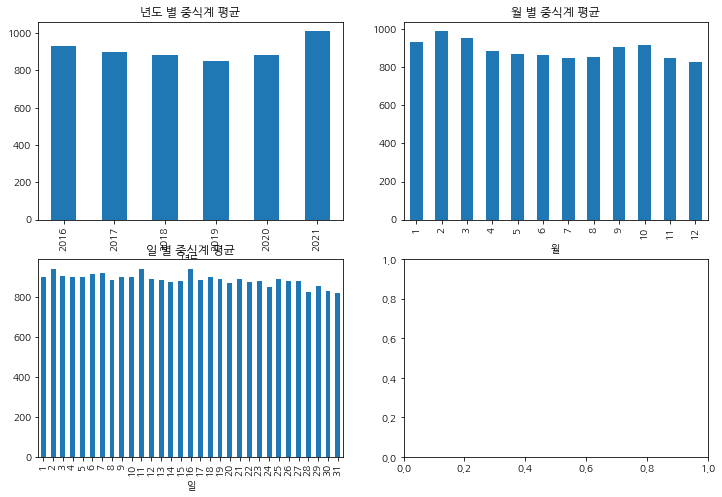

In [67]:
f, ax = plt.subplots(2, 2, figsize=(12, 8))
lunch_year.plot.bar(ax=ax[0, 0])
ax[0, 0].set_title('년도 별 중식계 평균')
lunch_month.plot.bar(ax=ax[0, 1])
ax[0, 1].set_title('월 별 중식계 평균')
lunch_day.plot.bar(ax=ax[1, 0])
ax[1, 0].set_title('일 별 중식계 평균')
plt.show()

* 년도 평균을 봤을 때, 19년도까지 좀 줄어들다가 20, 21년도로 오면서 계속 늘어나는 추세이다.
* 월별로 봐서는 12월로 갈 수록 떨어지는 경향을 보이고, 일별로 본 결과에서도 월말로 갈 수록 조금씩 떨어지는 것을 볼 수 있다.